In [71]:
from pandas import read_csv, DataFrame, concat
from datetime import datetime
import matplotlib.pyplot as pyplot
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM 
import numpy as np 

def parse(x):
    return datetime.strptime(x, '%m/%d/%Y')

# Data Loading
data_set = read_csv('march2020_2.csv', header=0, date_parser = parse)
data_set = data_set.iloc[:data_set['totalSoybeanMealSupply'].last_valid_index(),:] # Truncate dataset to those where every data is available 
'''
'closePrice','openPrice','highPrice','lowPrice','totalSoybeanMealSupply','totalSoybeanMealDemand','soybeanOilSupply','soybeanOilDemand','sunflowerSeedPrice','canolaPrice','peanutsPrice','flaxseedPrice','soybeanOilPrice','cottonseedOilPrice','sunflowerseedOilPrice','canolaOilPrice','peanutOilPrice','cornOilPrice','soybeanMealPrice','cottonseedmealPrice','sunflowerseedMealPrice','linseedMealPrice'
'''
target_col = ['closePrice','totalSoybeanMealSupply','totalSoybeanMealDemand','sunflowerseedMealPrice','soybeanMealPrice']
data_set = data_set.loc[:,target_col]

In [72]:
values = data_set.values
values = values.astype('float32')
'''
pyplot.figure()
for i,col in enumerate(interest):
    ax = pyplot.subplot(len(interest), 1, i+1)
    pyplot.plot([datetime.strptime(x,'%m/%d/%Y').date() for x in values[:,0]],values[:, col])
    pyplot.title(data_set.columns[col], y=0.7, loc='right')
    ax.locator_params(axis='y', nbins=4)
    ax.locator_params(axis='x', nbins=6)
pyplot.show()
'''

scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)




In [73]:
# Data Analysis
def series_to_supervised(data, y_col=0):
    agg = [] 
    lag = 10
    for i in range(lag, len(data)):
        row = np.concatenate((data[i-lag],[data[i][y_col]]))
        agg += [row]
    return agg

data = np.asarray(series_to_supervised(scaled))
train_count = int(len(data) * 0.8)
train_data = data[:train_count]
test_data = data[train_count:]
train_x, train_y = train_data[:,:-1], train_data[:,-1]
test_x, test_y = test_data[:,:-1], test_data[:,-1]

# Reshape input to have the form (sample, timestep, features)
train_x = train_x.reshape((train_x.shape[0],1,train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0],1,test_x.shape[1]))


Train on 317 samples, validate on 80 samples
Epoch 1/50
317/317 [==============================] - 2s 6ms/step - loss: 0.4541 - val_loss: 0.1962
Epoch 2/50
317/317 [==============================] - 0s 391us/step - loss: 0.1481 - val_loss: 0.1585
Epoch 3/50
317/317 [==============================] - 0s 416us/step - loss: 0.1268 - val_loss: 0.1556
Epoch 4/50
317/317 [==============================] - 0s 467us/step - loss: 0.1214 - val_loss: 0.1535
Epoch 5/50
317/317 [==============================] - 0s 467us/step - loss: 0.1172 - val_loss: 0.1522
Epoch 6/50
317/317 [==============================] - 0s 467us/step - loss: 0.1135 - val_loss: 0.1562
Epoch 7/50
317/317 [==============================] - 0s 442us/step - loss: 0.1112 - val_loss: 0.1543
Epoch 8/50
317/317 [==============================] - 0s 429us/step - loss: 0.1061 - val_loss: 0.1505
Epoch 9/50
317/317 [==============================] - 0s 454us/step - loss: 0.1040 - val_loss: 0.1491
Epoch 10/50
317/317 [==================

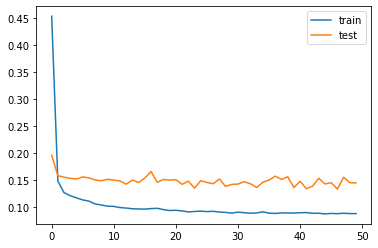

In [74]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_x, train_y, epochs=50, batch_size=9, validation_data=(test_x, test_y))
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

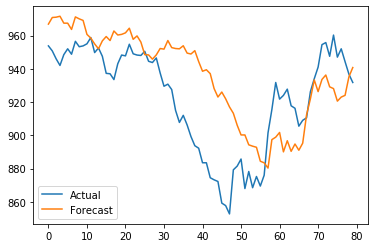

In [75]:
yhat = model.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], test_x.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_x[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

pyplot.figure()
pyplot.plot(inv_y, label = 'Actual')
pyplot.plot(inv_yhat, label = 'Forecast')
pyplot.legend()
pyplot.show()